In [35]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [36]:
data = pd.read_csv('diabetes.csv')

In [37]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [39]:
target_count()
target_percent()

In [40]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [41]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    

In [42]:
# Plotting 
missing_plot(data, 'Outcome')

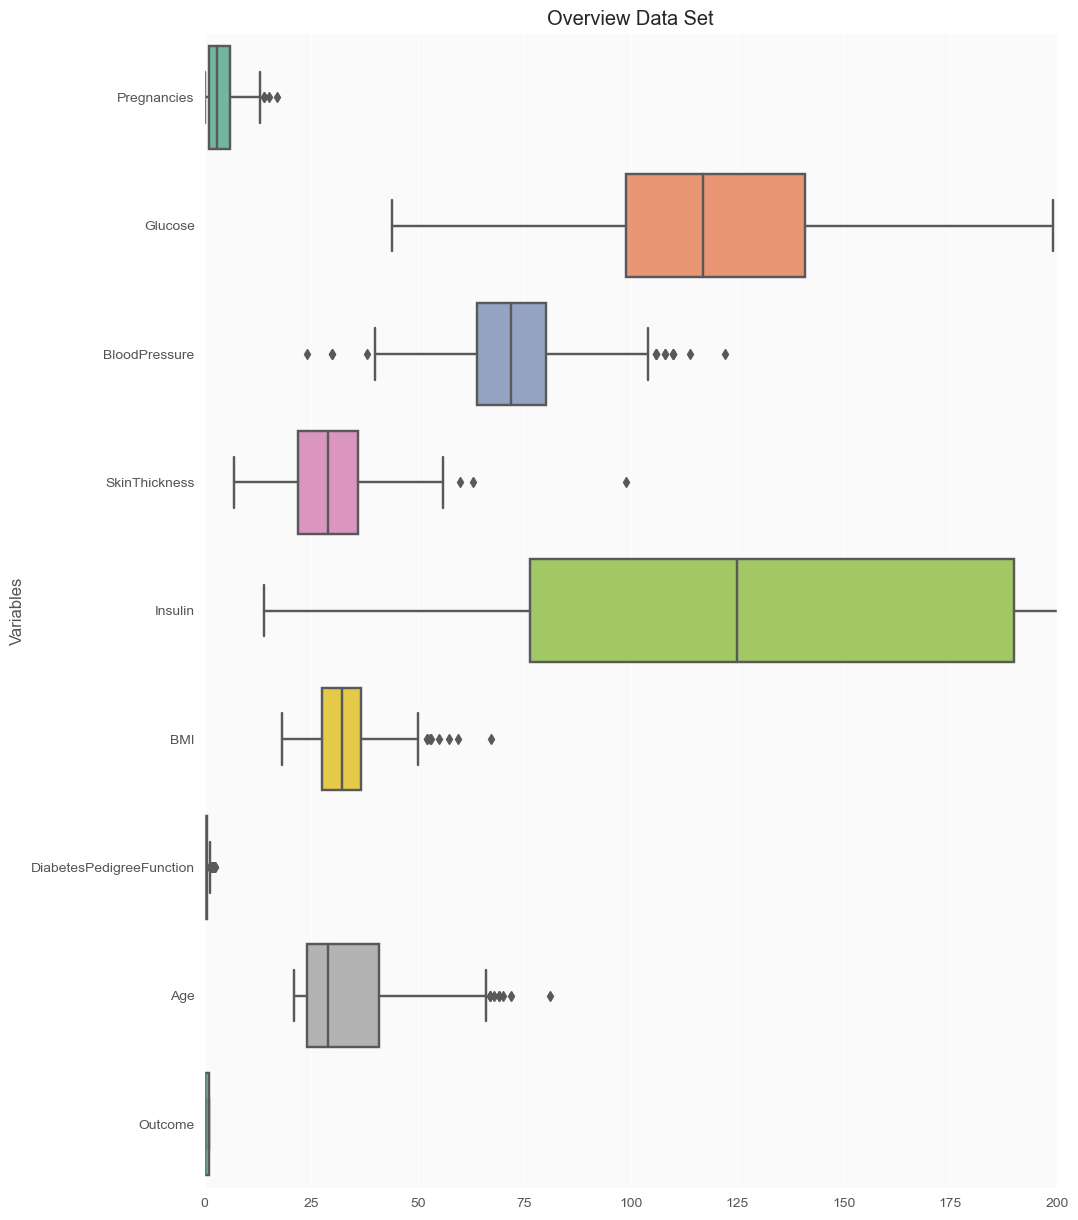

In [43]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

In [44]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [45]:
correlation_plot()

In [46]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [47]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [48]:
plot_distribution('Insulin', 0)

In [49]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [50]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

In [51]:
plot_distribution('Glucose', 0)

In [52]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [53]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

In [54]:
plot_distribution('SkinThickness', 10)

In [55]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [56]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [57]:
plot_distribution('BloodPressure', 5)

In [58]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [59]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

In [60]:
plot_distribution('BMI', 0)

In [61]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [62]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [63]:
#plot distribution 
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

In [64]:
missing_plot(data, 'Outcome')

<AxesSubplot:xlabel='Insulin'>

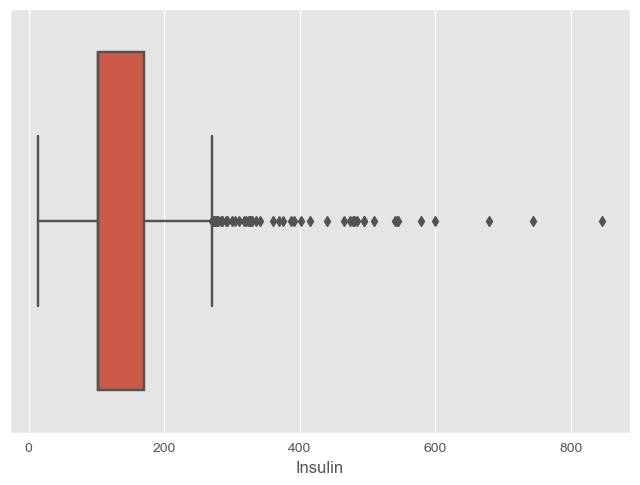

In [65]:
sns.boxplot(data['Insulin'])

In [66]:
df=data.copy()

<AxesSubplot:xlabel='Insulin'>

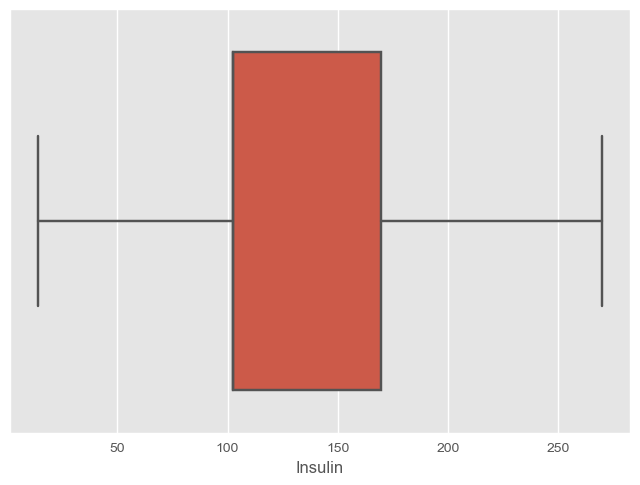

In [67]:
q1=df['Insulin'].quantile(0.25)
q3=df['Insulin'].quantile(0.75)
iqr=q3-q1

upperlimit=q3+(1.5*iqr)
lowerlimit=q1-(1.5*iqr)

df.loc[(df['Insulin']>upperlimit),'Insulin']=upperlimit
df.loc[(df['Insulin']<lowerlimit),'Insulin']=lowerlimit

sns.boxplot(df['Insulin'])

<AxesSubplot:xlabel='BMI'>

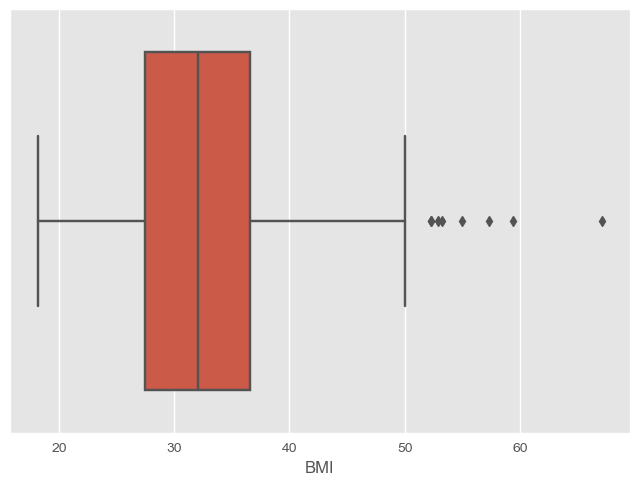

In [68]:
sns.boxplot(data['BMI'])

<AxesSubplot:xlabel='BMI'>

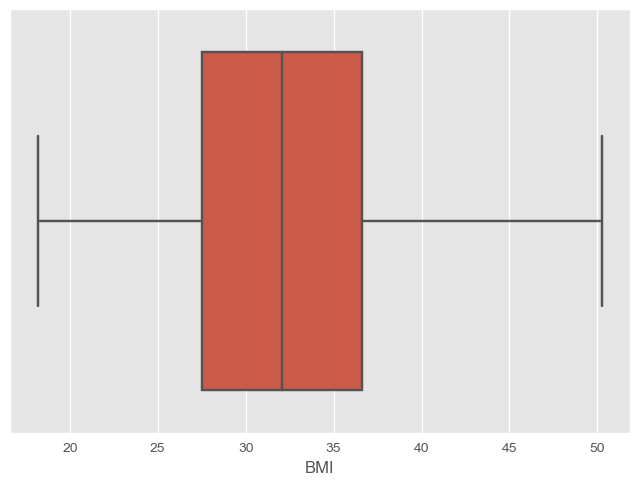

In [69]:
q1 = df['BMI'].quantile(0.25)
q3 = df['BMI'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df.loc[(df['BMI'] > upper_limit), 'BMI'] = upper_limit
df.loc[(df['BMI'] < lower_limit), 'BMI'] = lower_limit

sns.boxplot(df['BMI'])

<AxesSubplot:xlabel='Pregnancies'>

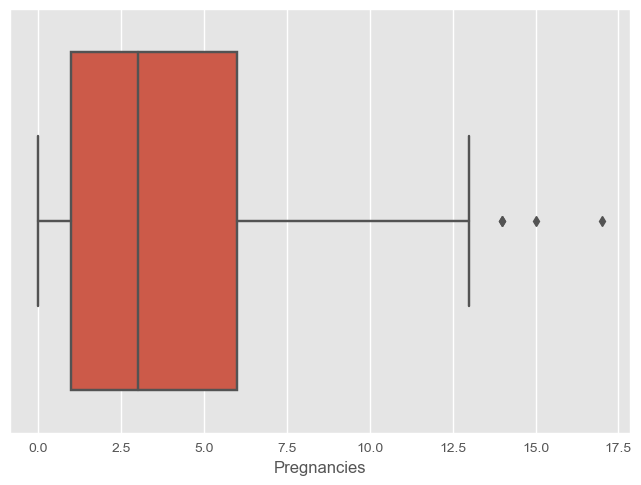

In [70]:
sns.boxplot(data['Pregnancies'])

<AxesSubplot:xlabel='Pregnancies'>

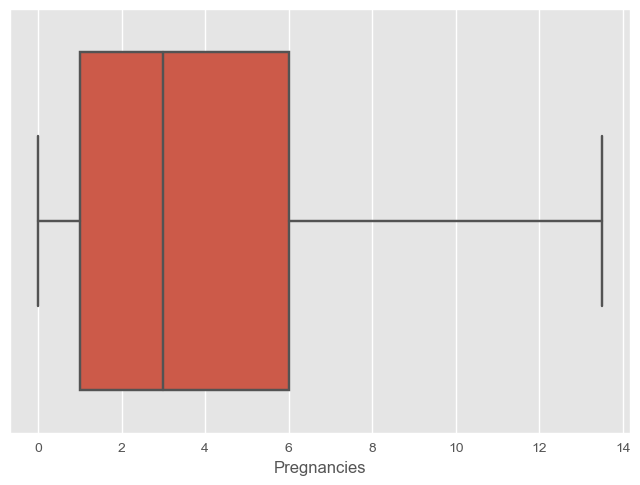

In [71]:
q1 = df['Pregnancies'].quantile(0.25)
q3 = df['Pregnancies'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df.loc[(df['Pregnancies'] > upper_limit), 'Pregnancies'] = upper_limit
df.loc[(df['Pregnancies'] < lower_limit), 'Pregnancies'] = lower_limit

sns.boxplot(df['Pregnancies'])


<AxesSubplot:xlabel='SkinThickness'>

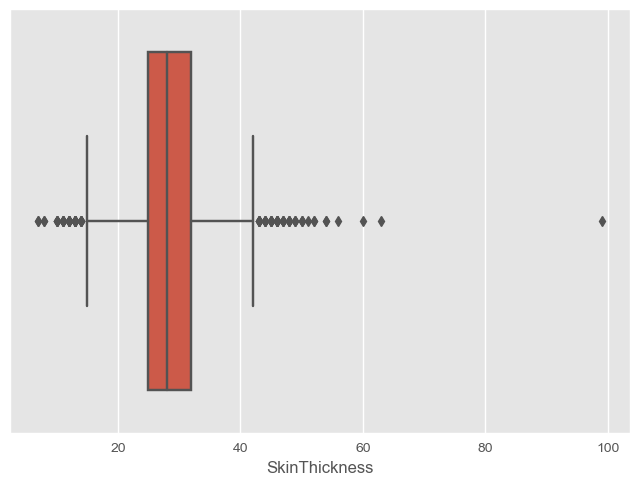

In [72]:
sns.boxplot(data['SkinThickness'])

<AxesSubplot:xlabel='SkinThickness'>

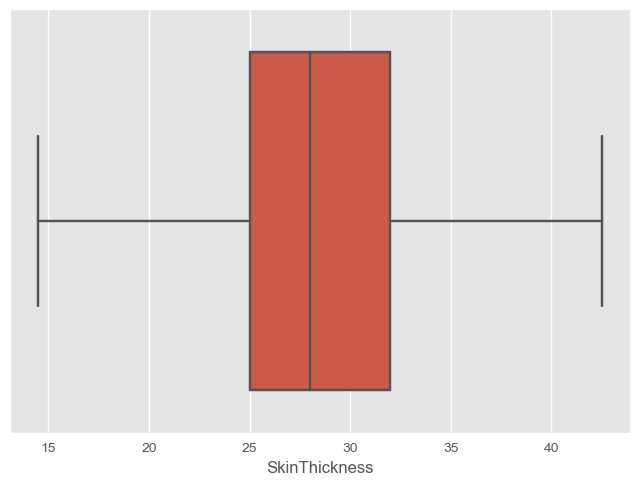

In [73]:
q1 = df['SkinThickness'].quantile(0.25)
q3 = df['SkinThickness'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df.loc[(df['SkinThickness'] > upper_limit), 'SkinThickness'] = upper_limit
df.loc[(df['SkinThickness'] < lower_limit), 'SkinThickness'] = lower_limit

sns.boxplot(df['SkinThickness'])

<AxesSubplot:xlabel='Glucose'>

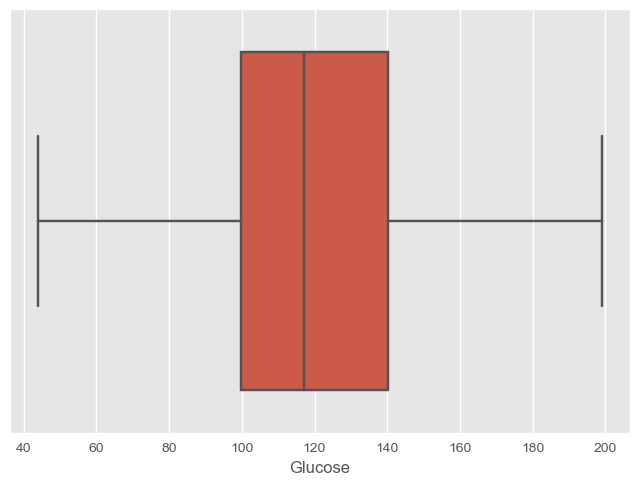

In [74]:
sns.boxplot(data['Glucose'])

<AxesSubplot:xlabel='BloodPressure'>

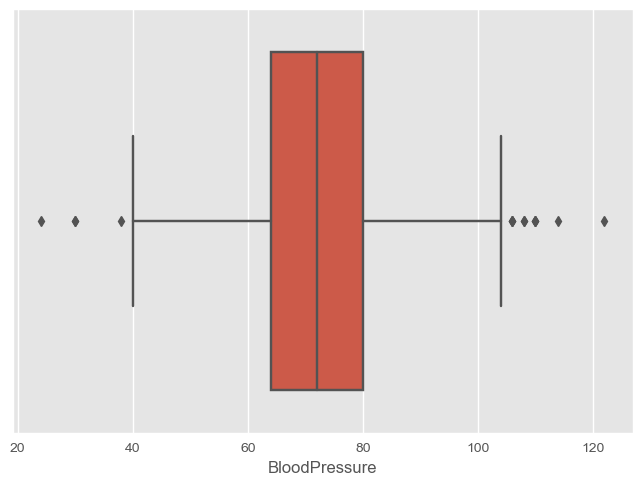

In [75]:
sns.boxplot(data['BloodPressure'])

<AxesSubplot:xlabel='BloodPressure'>

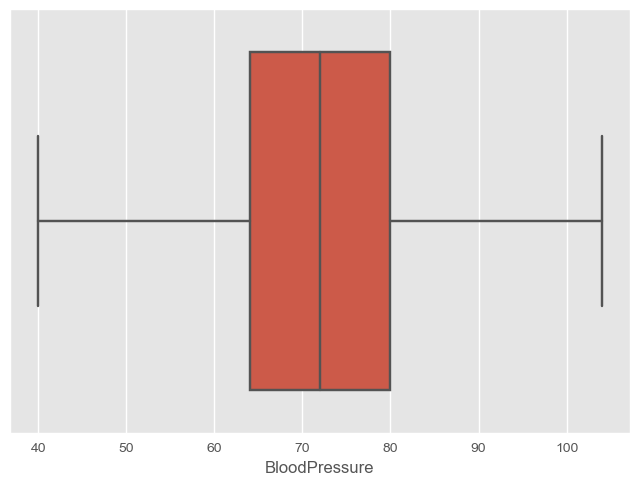

In [76]:
q1 = df['BloodPressure'].quantile(0.25)
q3 = df['BloodPressure'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df.loc[(df['BloodPressure'] > upper_limit), 'BloodPressure'] = upper_limit
df.loc[(df['BloodPressure'] < lower_limit), 'BloodPressure'] = lower_limit

sns.boxplot(df['BloodPressure'])

<AxesSubplot:xlabel='Age'>

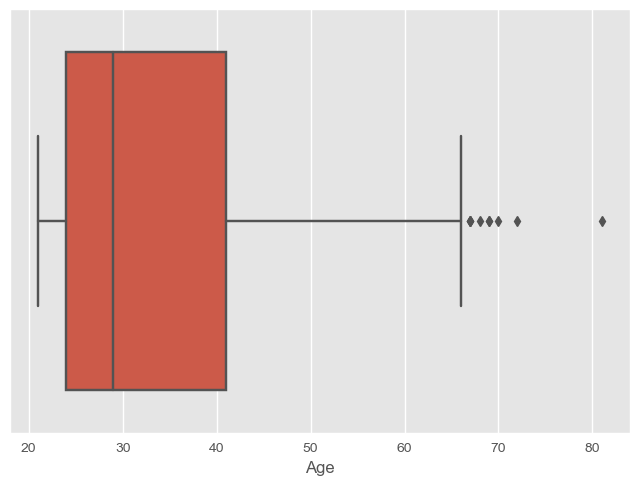

In [77]:
sns.boxplot(data['Age'])

<AxesSubplot:xlabel='Age'>

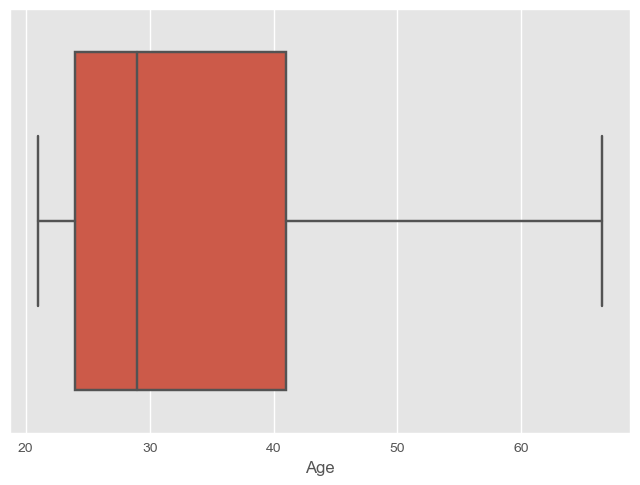

In [78]:
q1 = df['Age'].quantile(0.25)
q3 = df['Age'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df.loc[(df['Age'] > upper_limit), 'Age'] = upper_limit
df.loc[(df['Age'] < lower_limit), 'Age'] = lower_limit

sns.boxplot(df['Age'])

<AxesSubplot:xlabel='DiabetesPedigreeFunction'>

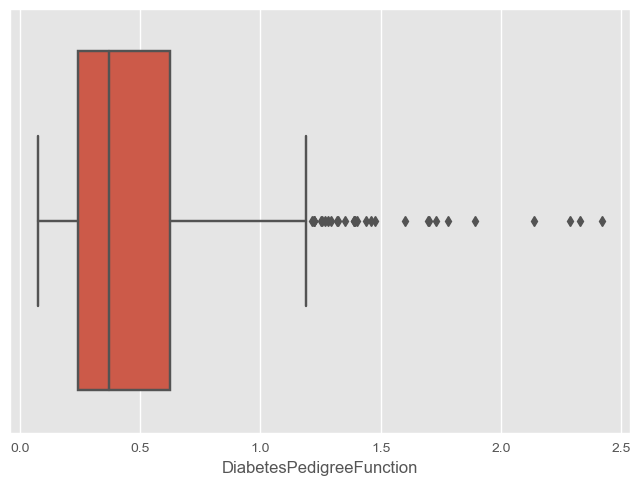

In [79]:
sns.boxplot(data['DiabetesPedigreeFunction'])

<AxesSubplot:xlabel='DiabetesPedigreeFunction'>

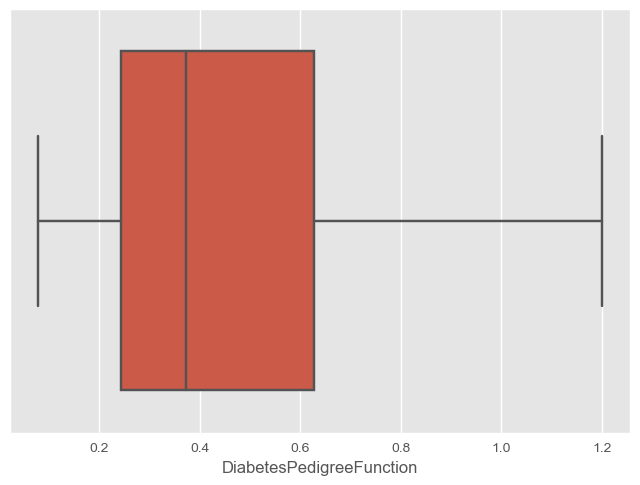

In [83]:
q1 = df['DiabetesPedigreeFunction'].quantile(0.25)
q3 = df['DiabetesPedigreeFunction'].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df.loc[(df['DiabetesPedigreeFunction'] > upper_limit), 'DiabetesPedigreeFunction'] = upper_limit
df.loc[(df['DiabetesPedigreeFunction'] < lower_limit), 'DiabetesPedigreeFunction'] = lower_limit

sns.boxplot(df['DiabetesPedigreeFunction'])

In [84]:
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [85]:
X = df.drop('Outcome', axis=1)  # Drop the 'Outcome' column from features
y = df['Outcome']  # Assign the 'Outcome' column as the target variable


In [86]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X is your feature matrix and y is your target variable
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction using SelectKBest with ANOVA F-value
# Selecting the top 5 features based on F-value
k_best_features = SelectKBest(score_func=f_classif, k=5)
X_train_selected = k_best_features.fit_transform(X_train, y_train)
X_test_selected = k_best_features.transform(X_test)

# Get the indices of the selected features
selected_indices = k_best_features.get_support(indices=True)

# Print the indices of selected features
print("Indices of selected features:", selected_indices)

# Optionally, you can print the names of the selected features
selected_feature_names = np.array(X.columns)[selected_indices]
print("Selected feature names:", selected_feature_names)


Indices of selected features: [1 3 4 5 7]
Selected feature names: ['Glucose' 'SkinThickness' 'Insulin' 'BMI' 'Age']


In [58]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your SVC model
svc_model = SVC(probability=True)  # probability=True to enable probability estimates

# Train the SVC model
svc_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_svc = svc_model.predict(X_val)
y_pred_proba_svc = svc_model.predict_proba(X_val)[:, 1]

# Compute evaluation metrics
accuracy_svc = accuracy_score(y_val, y_pred_svc)
precision_svc = precision_score(y_val, y_pred_svc)
recall_svc = recall_score(y_val, y_pred_svc)
f1_svc = f1_score(y_val, y_pred_svc)
auc_svc = roc_auc_score(y_val, y_pred_proba_svc)
conf_matrix_svc = confusion_matrix(y_val, y_pred_svc)

# Print evaluation metrics
print("Accuracy (SVC):", accuracy_svc)
print("Precision (SVC):", precision_svc)
print("Recall (SVC):", recall_svc)
print("F1 Score (SVC):", f1_svc)
print("AUC Score (SVC):", auc_svc)
print("Confusion Matrix (SVC):")
print(conf_matrix_svc)

# Print classification report
print("\nClassification Report (SVC):")
print(classification_report(y_val, y_pred_svc))


Accuracy (SVC): 0.8506493506493507
Precision (SVC): 0.7758620689655172
Recall (SVC): 0.8181818181818182
F1 Score (SVC): 0.7964601769911505
AUC Score (SVC): 0.89366391184573
Confusion Matrix (SVC):
[[86 13]
 [10 45]]

Classification Report (SVC):
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        99
           1       0.78      0.82      0.80        55

    accuracy                           0.85       154
   macro avg       0.84      0.84      0.84       154
weighted avg       0.85      0.85      0.85       154



In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your KNN model
knn_model = KNeighborsClassifier()

# Train the KNN model
knn_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_knn = knn_model.predict(X_val)
# For KNN, there's no predict_proba method, as it doesn't output probabilities directly

# Compute evaluation metrics
accuracy_knn = accuracy_score(y_val, y_pred_knn)
precision_knn = precision_score(y_val, y_pred_knn)
recall_knn = recall_score(y_val, y_pred_knn)
f1_knn = f1_score(y_val, y_pred_knn)
# ROC AUC score is not applicable for KNN
conf_matrix_knn = confusion_matrix(y_val, y_pred_knn)

# Print evaluation metrics
print("Accuracy (KNN):", accuracy_knn)
print("Precision (KNN):", precision_knn)
print("Recall (KNN):", recall_knn)
print("F1 Score (KNN):", f1_knn)
print("Confusion Matrix (KNN):")
print(conf_matrix_knn)

# Print classification report
print("\nClassification Report (KNN):")
print(classification_report(y_val, y_pred_knn))


Accuracy (KNN): 0.8246753246753247
Precision (KNN): 0.75
Recall (KNN): 0.7636363636363637
F1 Score (KNN): 0.7567567567567568
Confusion Matrix (KNN):
[[85 14]
 [13 42]]

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.87      0.86      0.86        99
           1       0.75      0.76      0.76        55

    accuracy                           0.82       154
   macro avg       0.81      0.81      0.81       154
weighted avg       0.83      0.82      0.83       154



In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your Logistic Regression model
lr_model = LogisticRegression()

# Train the Logistic Regression model
lr_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Compute evaluation metrics
accuracy_lr = accuracy_score(y_val, y_pred_lr)
precision_lr = precision_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
auc_lr = roc_auc_score(y_val, y_pred_proba_lr)
conf_matrix_lr = confusion_matrix(y_val, y_pred_lr)

# Print evaluation metrics
print("Accuracy (LR):", accuracy_lr)
print("Precision (LR):", precision_lr)
print("Recall (LR):", recall_lr)
print("F1 Score (LR):", f1_lr)
print("AUC Score (LR):", auc_lr)
print("Confusion Matrix (LR):")
print(conf_matrix_lr)

# Print classification report
print("\nClassification Report (LR):")
print(classification_report(y_val, y_pred_lr))


Accuracy (LR): 0.8051948051948052
Precision (LR): 0.7358490566037735
Recall (LR): 0.7090909090909091
F1 Score (LR): 0.7222222222222222
AUC Score (LR): 0.8683195592286501
Confusion Matrix (LR):
[[85 14]
 [16 39]]

Classification Report (LR):
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        99
           1       0.74      0.71      0.72        55

    accuracy                           0.81       154
   macro avg       0.79      0.78      0.79       154
weighted avg       0.80      0.81      0.80       154



In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your Decision Tree model
dt_model = DecisionTreeClassifier()

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_dt = dt_model.predict(X_val)
# Decision Trees don't provide probabilities directly, so we cannot calculate ROC AUC score

# Compute evaluation metrics
accuracy_dt = accuracy_score(y_val, y_pred_dt)
precision_dt = precision_score(y_val, y_pred_dt)
recall_dt = recall_score(y_val, y_pred_dt)
f1_dt = f1_score(y_val, y_pred_dt)
# Since Decision Trees don't provide probabilities directly, we can't calculate AUC
conf_matrix_dt = confusion_matrix(y_val, y_pred_dt)

# Print evaluation metrics
print("Accuracy (DT):", accuracy_dt)
print("Precision (DT):", precision_dt)
print("Recall (DT):", recall_dt)
print("F1 Score (DT):", f1_dt)
print("Confusion Matrix (DT):")
print(conf_matrix_dt)

# Print classification report
print("\nClassification Report (DT):")
print(classification_report(y_val, y_pred_dt))


Accuracy (DT): 0.8311688311688312
Precision (DT): 0.7457627118644068
Recall (DT): 0.8
F1 Score (DT): 0.7719298245614035
Confusion Matrix (DT):
[[84 15]
 [11 44]]

Classification Report (DT):
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        99
           1       0.75      0.80      0.77        55

    accuracy                           0.83       154
   macro avg       0.81      0.82      0.82       154
weighted avg       0.83      0.83      0.83       154



In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your Random Forest model
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Compute evaluation metrics
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
auc_rf = roc_auc_score(y_val, y_pred_proba_rf)
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)

# Print evaluation metrics
print("Accuracy (RF):", accuracy_rf)
print("Precision (RF):", precision_rf)
print("Recall (RF):", recall_rf)
print("F1 Score (RF):", f1_rf)
print("AUC Score (RF):", auc_rf)
print("Confusion Matrix (RF):")
print(conf_matrix_rf)

# Print classification report
print("\nClassification Report (RF):")
print(classification_report(y_val, y_pred_rf))


Accuracy (RF): 0.8701298701298701
Precision (RF): 0.8070175438596491
Recall (RF): 0.8363636363636363
F1 Score (RF): 0.8214285714285714
AUC Score (RF): 0.9348025711662076
Confusion Matrix (RF):
[[88 11]
 [ 9 46]]

Classification Report (RF):
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        99
           1       0.81      0.84      0.82        55

    accuracy                           0.87       154
   macro avg       0.86      0.86      0.86       154
weighted avg       0.87      0.87      0.87       154



In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',         # Evaluation metric
    'eta': 0.1,                       # Learning rate
    'max_depth': 6,                   # Maximum depth of the tree
    'min_child_weight': 1,            # Minimum sum of instance weight needed in a child
    'subsample': 0.8,                 # Subsample ratio of the training instances
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 42                        # Random seed
}

# Convert your data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define a watchlist to observe performance on the validation set
watchlist = [(dtrain, 'train'), (dval, 'eval')]

# Train the model with early stopping
num_rounds = 1000  # Maximum number of boosting rounds
early_stopping_rounds = 50  # Number of rounds to stop if no improvement
model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

# Predict on the validation set
y_pred = model.predict(dval)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
auc = roc_auc_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred_binary)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_binary))


[0]	train-logloss:0.59095	eval-logloss:0.61200
[1]	train-logloss:0.53800	eval-logloss:0.56510
[2]	train-logloss:0.49106	eval-logloss:0.52534
[3]	train-logloss:0.44909	eval-logloss:0.48993
[4]	train-logloss:0.41576	eval-logloss:0.46042
[5]	train-logloss:0.39394	eval-logloss:0.45064
[6]	train-logloss:0.36756	eval-logloss:0.42959
[7]	train-logloss:0.34675	eval-logloss:0.41825
[8]	train-logloss:0.32257	eval-logloss:0.40205
[9]	train-logloss:0.30399	eval-logloss:0.38695
[10]	train-logloss:0.28481	eval-logloss:0.37214
[11]	train-logloss:0.26911	eval-logloss:0.36035
[12]	train-logloss:0.25430	eval-logloss:0.35046
[13]	train-logloss:0.24115	eval-logloss:0.34117
[14]	train-logloss:0.22846	eval-logloss:0.33490
[15]	train-logloss:0.21802	eval-logloss:0.32908
[16]	train-logloss:0.20719	eval-logloss:0.32501
[17]	train-logloss:0.19871	eval-logloss:0.32082
[18]	train-logloss:0.18927	eval-logloss:0.31912
[19]	train-logloss:0.18124	eval-logloss:0.31688
[20]	train-logloss:0.17439	eval-logloss:0.31343
[2

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your AdaBoost model
ada_model = AdaBoostClassifier()

# Train the AdaBoost model
ada_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_ada = ada_model.predict(X_val)
y_pred_proba_ada = ada_model.predict_proba(X_val)[:, 1]

# Compute evaluation metrics
accuracy_ada = accuracy_score(y_val, y_pred_ada)
precision_ada = precision_score(y_val, y_pred_ada)
recall_ada = recall_score(y_val, y_pred_ada)
f1_ada = f1_score(y_val, y_pred_ada)
auc_ada = roc_auc_score(y_val, y_pred_proba_ada)
conf_matrix_ada = confusion_matrix(y_val, y_pred_ada)

# Print evaluation metrics
print("Accuracy (AdaBoost):", accuracy_ada)
print("Precision (AdaBoost):", precision_ada)
print("Recall (AdaBoost):", recall_ada)
print("F1 Score (AdaBoost):", f1_ada)
print("AUC Score (AdaBoost):", auc_ada)
print("Confusion Matrix (AdaBoost):")
print(conf_matrix_ada)

# Print classification report
print("\nClassification Report (AdaBoost):")
print(classification_report(y_val, y_pred_ada))



Accuracy (AdaBoost): 0.8311688311688312
Precision (AdaBoost): 0.7457627118644068
Recall (AdaBoost): 0.8
F1 Score (AdaBoost): 0.7719298245614035
AUC Score (AdaBoost): 0.922038567493113
Confusion Matrix (AdaBoost):
[[84 15]
 [11 44]]

Classification Report (AdaBoost):
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        99
           1       0.75      0.80      0.77        55

    accuracy                           0.83       154
   macro avg       0.81      0.82      0.82       154
weighted avg       0.83      0.83      0.83       154



In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Train the Gradient Boosting model
gb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_gb = gb_model.predict(X_val)
y_pred_proba_gb = gb_model.predict_proba(X_val)[:, 1]

# Compute evaluation metrics
accuracy_gb = accuracy_score(y_val, y_pred_gb)
precision_gb = precision_score(y_val, y_pred_gb)
recall_gb = recall_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb)
auc_gb = roc_auc_score(y_val, y_pred_proba_gb)
conf_matrix_gb = confusion_matrix(y_val, y_pred_gb)

# Print evaluation metrics
print("Accuracy (Gradient Boosting):", accuracy_gb)
print("Precision (Gradient Boosting):", precision_gb)
print("Recall (Gradient Boosting):", recall_gb)
print("F1 Score (Gradient Boosting):", f1_gb)
print("AUC Score (Gradient Boosting):", auc_gb)
print("Confusion Matrix (Gradient Boosting):")
print(conf_matrix_gb)

# Print classification report
print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_val, y_pred_gb))


Accuracy (Gradient Boosting): 0.8636363636363636
Precision (Gradient Boosting): 0.8035714285714286
Recall (Gradient Boosting): 0.8181818181818182
F1 Score (Gradient Boosting): 0.8108108108108109
AUC Score (Gradient Boosting): 0.9379247015610651
Confusion Matrix (Gradient Boosting):
[[88 11]
 [10 45]]

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        99
           1       0.80      0.82      0.81        55

    accuracy                           0.86       154
   macro avg       0.85      0.85      0.85       154
weighted avg       0.86      0.86      0.86       154



In [67]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Split your data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'early_stopping_rounds': 50,  # Specify early stopping directly in params
    'verbose_eval': 50             # Print evaluation results every 50 rounds
}

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])

# Predict probabilities on the validation set
y_pred_proba = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred_binary)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)
print("Confusion Matrix:")
print(conf_matrix)


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: